# Modeling

## Load Packages

In [3]:
from operator import mod
from os import getcwd
from os.path import exists, join

import joblib
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
import pandas as pd
from ydata_profiling import ProfileReport

In [2]:
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import recall_score

from sklearn import tree
from sklearn.decomposition import PCA, SparsePCA

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image
import warnings

In [1]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

## Load Data

In [4]:
cdc_survey = pd.read_csv('../data/cdc_nhanes_survey_responses_clean.csv')

# filter to pregnant moms
cdc_survey_pmom = cdc_survey[cdc_survey['has_been_pregnant'] == 1]
cdc_survey_pmom

,Unnamed: 0,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ270,ALQ280,ALQ290,ALQ151,...,has_health_insurance,has_health_insurance_gap,has_smoked_tabacco_last_5days,is_male,is_usa_born,has_diabetes,has_overweight_diagnosis,has_tried_to_lose_weight_12mo,has_been_pregnant,monthly_poverty_index
5,5,109284.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,0,0.0,0.0,1.0,1.0,1.0,NaN
7,7,109290.0,1.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,0.0,0.0,0,1.0,1.0,0.0,1.0,1.0,4.80
8,8,109291.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0,1.0,0.0,1.0,0.0,1.0,NaN
11,11,109295.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,4.37
14,14,109300.0,1.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,2.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,8950,124802.0,1.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,NaN
8951,8951,124803.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,1.18
8957,8957,124812.0,1.0,6.000000e+00,3.0,8.000000e+00,10.0,9.0,5.397605e-79,2.0,...,0.0,NaN,0.0,0,1.0,0.0,0.0,0.0,1.0,3.66
8958,8958,124813.0,1.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,1.0,0.0,0,0.0,0.0,0.0,1.0,1.0,NaN


## Training Step

### Features to Use

In [5]:
cols_to_keep = [
    # Target
    'MDD',
    # Depression screener
    'little_interest_in_doing_things',
    'feeling_down_depressed_hopeless',
    'trouble_falling_or_staying_asleep',
    'feeling_tired_or_having_little_energy',
    'poor_appetitie_or_overeating',
    'feeling_bad_about_yourself',
    'trouble_concentrating',
    'moving_or_speaking_to_slowly_or_fast',
    'thoughts_you_would_be_better_off_dead',
    'difficult_doing_daytoday_tasks',
    # Alcohol & smoking
    'has_smoked_tabacco_last_5days',
    'alcoholic_drinks_past_12mo',    
    # Diet & Nutrition
    'how_healthy_is_your_diet',    
    'count_lost_10plus_pounds',
    'has_tried_to_lose_weight_12mo',    
    'count_tried_to_lose_weight_youth',    
    # Physical health & Medical History
    'count_days_seen_doctor_12mo',
    'duration_last_healthcare_visit',        
    'count_days_moderate_recreational_activity',   
    'count_minutes_moderate_recreational_activity',
    'count_minutes_moderate_sedentary_activity',
    'count_days_physical_activity_youth',   
    'general_health_condition',    
    'has_diabetes',
    'has_overweight_diagnosis',         
    # Demographic data
    'food_security_level_household',   
    'food_security_level_adult',    
    'monthly_poverty_index_category',
    'monthly_poverty_index',
    'count_hours_worked_last_week',
    'age_in_years',   
    'education_level',
    'is_usa_born',    
    'has_health_insurance',
    'has_health_insurance_gap'   
]
len(cols_to_keep)

36

### Create Test & Train Datasets

In [6]:
cdc_survey_pmom = cdc_survey_pmom[cols_to_keep]
cdc_survey_pmom

,MDD,little_interest_in_doing_things,feeling_down_depressed_hopeless,trouble_falling_or_staying_asleep,feeling_tired_or_having_little_energy,poor_appetitie_or_overeating,feeling_bad_about_yourself,trouble_concentrating,moving_or_speaking_to_slowly_or_fast,thoughts_you_would_be_better_off_dead,...,food_security_level_household,food_security_level_adult,monthly_poverty_index_category,monthly_poverty_index,count_hours_worked_last_week,age_in_years,education_level,is_usa_born,has_health_insurance,has_health_insurance_gap
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,38.0,44.0,2.0,0.0,0.0,NaN
7,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,4.80,60.0,68.0,5.0,1.0,1.0,0.0
8,0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,...,1.0,1.0,NaN,NaN,8.0,42.0,5.0,1.0,1.0,0.0
11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,4.37,43.0,54.0,1.0,0.0,1.0,0.0
14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,2.89,60.0,54.0,5.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,NaN,NaN,46.0,5.0,0.0,1.0,0.0
8951,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,1.0,1.18,NaN,46.0,4.0,0.0,1.0,0.0
8957,1,1.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,3.0,3.66,NaN,62.0,4.0,1.0,0.0,NaN
8958,0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,40.0,43.0,5.0,0.0,1.0,1.0


In [7]:
# Create test & train data

X = cdc_survey_pmom.iloc[:,1:].values
y = cdc_survey_pmom['MDD'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# QA splits 
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2729, 35)
(683, 35)
(2729,)
(683,)


In [8]:
def plot_confusion_matrix(y_test, pred_labels):
    """
    Function that displays a confusion matrix for provided true and predicted classes
    """
    #print(f'cover type 1 and type 2 total correct {np.sum(np.diag(metrics.confusion_matrix(y_test, pred_labels))[:2])}')

    cm = confusion_matrix(y_test, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,5))
    disp = disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')    
    plt.grid(False)
    plt.show()
    return

def baseline_models(
    X_train, 
    y_train, 
    X_test, 
    y_test,
    do_smote=True,
    show_confusion_matrix=True,
    show_score_dataframe=True):
    """
    Function that trains and makes predictions using 5 of the classifiers went over during the class.
    Meant as a helper function for easier testing of different modeling pipelines.
    """


    #  do_smote
    if do_smote == True:
        # have to impute first because smote won't take nulls
        my_imputer = SimpleImputer()
        X_train = my_imputer.fit_transform(X_train)
        X_test = my_imputer.fit_transform(X_test)

        print(X_train.shape)
        print(X_test.shape)

        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # after smote oversampling
        print(X_train.shape)

    # K-Nearest Neighbors
    knn = make_pipeline(SimpleImputer(), RobustScaler(), KNeighborsClassifier())
    knn.fit(X_train, y_train)
    pred_labels_knn  = knn.predict(X_test)
    score_knn = recall_score(y_test, pred_labels_knn, average='macro')
    
    # Logistic Regression
    lm = make_pipeline(SimpleImputer(), RobustScaler(), LogisticRegression()) 
    lm.fit(X_train, y_train)
    pred_labels_lr  = lm.predict(X_test)
    score_lr = recall_score(y_test, pred_labels_lr, average='macro')
        
    # Bernoulii Naive Bayes
    bnb = make_pipeline(SimpleImputer(), RobustScaler(), BernoulliNB())  
    bnb.fit(X_train, y_train)
    pred_labels_bnb  = bnb.predict(X_test)
    score_bnb = recall_score(y_test, pred_labels_bnb, average='macro')
        
    # Gaussian Naive Bayes
    gnb = make_pipeline(SimpleImputer(), RobustScaler(), GaussianNB())
    gnb.fit(X_train, y_train)
    score_gnb = gnb.score(X_test, y_test)
    pred_labels_gnb  = gnb.predict(X_test)

    # Random Forest
    rf = make_pipeline(SimpleImputer(), RobustScaler(), RandomForestClassifier(random_state=0))
    rf.fit(X_train, y_train)
    pred_labels_rf  = rf.predict(X_test)
    predictions_posterior_rf = rf.predict_proba(X_test)
    score_rf = recall_score(y_test, pred_labels_rf, average='macro')

    # make dataframe with scores
    scores = {
        'Model' : ['Knn','Logistic Regression', 'Bernoulli Naive Bayes', 'Gaussian Naive Bayes' ,'Random Forest'],
        'Recall' : [score_knn, score_lr, score_bnb, score_gnb, score_rf]
    }
    scores = pd.DataFrame(scores).sort_values('Recall',ascending=False)
    
    if show_score_dataframe:
        display(scores.style.set_table_attributes('style="font-size: 17px"').hide_index())
    
    if show_confusion_matrix:
        print('\nK-Nearest Neighbors Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_knn)
        print('Logistic Regression Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_lr)
        print('Bernoulli Naive Bayes Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_bnb)
        print('Gaussian Naive Bayes Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_gnb)
        print('Random Forest Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_rf)

    return scores

## Test Step

(2729, 33)
(683, 33)
(4896, 33)


/Users/orencarmeli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model,Recall
Gaussian Naive Bayes,0.786237
Logistic Regression,0.715219
Bernoulli Naive Bayes,0.674840
Knn,0.608597
Random Forest,0.527731



K-Nearest Neighbors Confusion Matrix


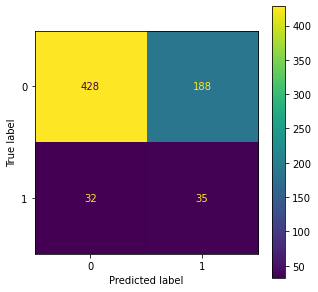

Logistic Regression Confusion Matrix


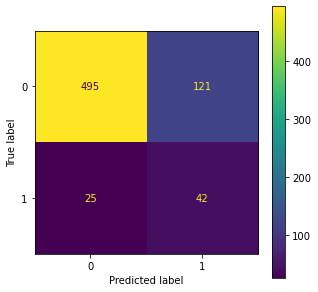

Bernoulli Naive Bayes Confusion Matrix


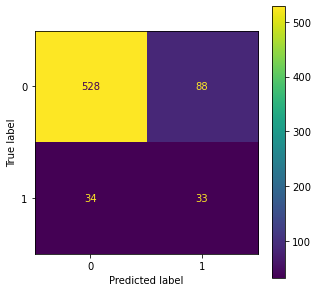

Gaussian Naive Bayes Confusion Matrix


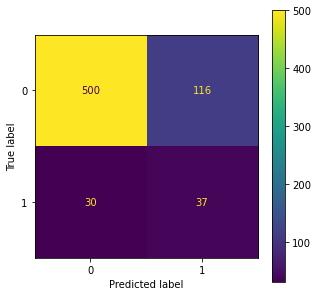

Random Forest Confusion Matrix


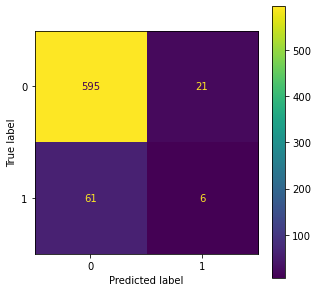

In [9]:
baseline_accuracies = baseline_models(X_train, y_train, X_test, y_test, do_smote=True)

/Users/orencarmeli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model,Recall
Gaussian Naive Bayes,0.847731
Bernoulli Naive Bayes,0.666408
Knn,0.517518
Logistic Regression,0.516706
Random Forest,0.504216



K-Nearest Neighbors Confusion Matrix


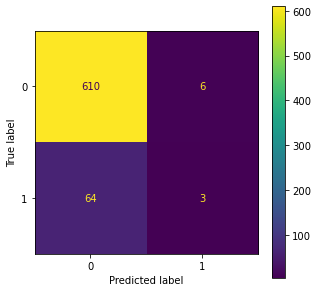

Logistic Regression Confusion Matrix


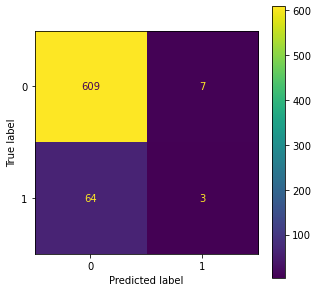

Bernoulli Naive Bayes Confusion Matrix


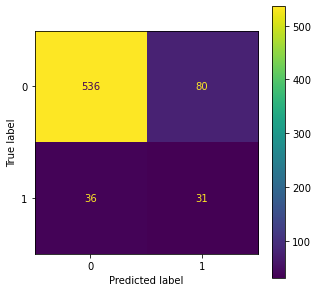

Gaussian Naive Bayes Confusion Matrix


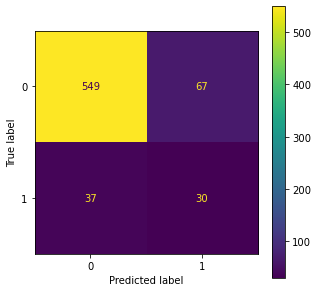

Random Forest Confusion Matrix


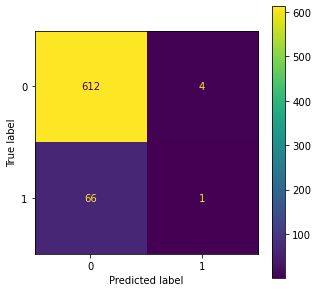

In [10]:
baseline_accuracies = baseline_models(X_train, y_train, X_test, y_test, do_smote=False)

## Transform pipeline
SVG is terrible, but need to do some gridsearch on above baselines

In [11]:
# Model Pipeline
processing_pipeline = make_pipeline(SimpleImputer(), RobustScaler(), SVR())

params = {
    "simpleimputer__strategy": ["mean", "median"],
    "robustscaler__quantile_range": [(25.0, 75.0), (30.0, 70.0)],
    "svr__C": [0.1, 1.0],
    "svr__gamma": ["auto", 0.1],
}

grid = GridSearchCV(processing_pipeline, param_grid=params, n_jobs=-1, cv=5, verbose=3)

model_filename = "model_pipeline.pkl"
model_path = join(getcwd(), model_filename)
print(model_path)
grid.fit(X_train, y_train)

print(f"Train R^2 Score : {grid.best_estimator_.score(X_train, y_train):.3f}")
print(f"Test R^2 Score : {grid.best_estimator_.score(X_test, y_test):.3f}")
print(f"Best R^2 Score Through Grid Search : {grid.best_score_:.3f}")
print(f"Best Parameters : {grid.best_params_}")


/Users/orencarmeli/Desktop/capstone210-ppd-carmeli_chari_hand_lee/modeling/model_pipeline.pkl
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Train R^2 Score : 0.514
Test R^2 Score : -0.013
Best R^2 Score Through Grid Search : 0.039
Best Parameters : {'robustscaler__quantile_range': (25.0, 75.0), 'simpleimputer__strategy': 'median', 'svr__C': 1.0, 'svr__gamma': 'auto'}


## Misc Code

In [ ]:
ProfileReport(df_cdc_clean, title="Profiling Report")